In [15]:
! pip install numpy matplotlib trimesh scipy tqdm opencv-python

# Problem 4-4: Point cloud registration 2.0. Non-linear optimization **(3 pts + 1.6 pts bonus)**

##In this homework, we will continue with the problem of points cloud registration, in particular finding the rigid-body motion that unites two point clouds. Instead of orthogonal procrustes problem that uses SVD we will use iterative optimization methods. This will allow us to achieve more control over the problem and solve more complicated cases like outliers contaminated data or define different objectives compared to the Least Squares approach.

##We will work with synthetic data again, namely point clouds sampled on the surface of 3D models of some objects (like water bottle from the previous time).

### Prepared by **Ostap Viniavskyi**

## Completed by:
*   Roman Kovalchuk
*   Eduard Pekach


In [16]:
from typing import Tuple, List, Optional

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
import trimesh
from scipy.spatial.transform import Rotation

In [17]:
# read points in the source and target positions
def read_obj(fname: str) -> np.ndarray:
    """Read .obj file containing point cloud using trimesh library."""
    with open(fname) as f:
        data = trimesh.exchange.obj.load_obj(f)
    return data['vertices']


# plot predictions X - in blue, Y - in read
def plot_predictions(X, Y, R, T):
    X = X @ R.T + T

    fig = plt.figure(figsize=(17, 17))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2., alpha=0.5)

    # ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c='r', s=2., alpha=0.5)
    plt.legend(['X', 'Y'])

    plt.title('Points clouds X and Y aligned by predicted R_pred, T_pred')

    plt.show()


# error metrics
def rigid_motion_error(R_true: np.ndarray, R_pred: np.ndarray,
                       T_true: np.ndarray, T_pred: np.ndarray) -> Tuple[float, float]:
    """
    Calculate error in rigid body motion: rotation and translation separately.
    For rotation compute minimal angle that transforms one rotation into other.
    For translation simply compute distance between two vectors.
    Args:
        R_true: true rotation; shape: (3, 3)
        R_pred: predicted rotation; shape: (3, 3)
        T_true: true translation; shape: (3,)
        T_pred: predicted translation; shape: (3,)
    Returns:
        rot_err: error in rotation in angles
        trans_err: error in translation in meters (or any other units)
    """
    cos = (np.trace(np.dot(R_true.T, R_pred)) - 1) / 2
    cos = np.clip(cos, -1., 1.)  # numercial errors can make it out of bounds
    rot_err = np.rad2deg(np.abs(np.arccos(cos)))
    trans_err = np.linalg.norm(T_true - T_pred)
    return rot_err, trans_err

## **Task 1 (1 pts + 0.3 bonus pts).** Gauss-Newton for Rotation estimation

In this task we will start from the simplest problem of estimating rotation between two point clouds. Translation in assumed to be zero. Also, the correspondences are assumed to be known for now.

Here we will be working with the following file:
- `bottle-model-samples-10k.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location

We define some ground truth rotation $R$ and transform with it the source point cloud $X$. Also, we add zero-mean gaussian noise to the target point cloud Y.
Thus, each points $y_i$ from $Y$ is defined as follows:
$$y_i = Rx_i + \epsilon$$
$$\epsilon \sim N(0, \sigma^2)$$

The task is to find the rotation using Gauss-Newton method to solve non-linear LS problem that arises here.
Firstly, we need to identify the parameters that we would like to optimize. Obviously, it is the rotation that we want to find. But the rotation transformation is represented as 3x3 matrix with 9 parameters. Should we use all 9 parameters and optimize over them?





### **Task 1.1 (0.2 pts)** 
Explain why optimizing over all 9 values in rotation matrix as free parameters is not going to work. State two approaches that can be used to alleviate the problem.

---
Optimizing over all 9 values in the rotation matrix as free parameters is not practical because it introduces redundancy and constraints that hinder convergence. Instead, we can use parameterizations that enforce orthogonality constraints, such as Euler angles or quaternions, to reduce the number of parameters to optimize. Another approach is to directly parameterize the rotation matrix with a minimal set of parameters, such as the axis-angle representation, which avoids redundant parameters and simplifies the optimization process.

---


In our case, we will parametrize rotation with the axis-angle representation, or more specifically by a 3D vector $w$, which has its direction as axis of rotation and norm as the angle of rotation. By the means of [Rodrigues formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) we can convert axis-angle representation to the rotation matrix.
The transformation is non-linear and that's where the non-linear nature of our problem arises. Let's denote the Rodrigues conversion from parameters $w$ to matrix $R$ by transformation $R = R(w)$. [The Jacobian of this transformation](https://arxiv.org/pdf/1312.0788.pdf) is 9x3 matrix (since we have 3 input variables and 9 outputs -- elements of the rotation matrix).
Both Rodrigues transformation and its Jacobian are a bit tricky to derive, but luckily we have the code implemented in the [OpenCV library](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac).

```cv2.Rodrigues``` function takes as an input axis-angle vector $w$ and returns both the rotation matrix $R$ and the Jacobian of the transformation evaluated at the input point.

Taking it all into account we can now write the problem more formally. The 3-dimensional residuals are defined as follows: $$\mathbf{r}_i(w) = R(w)\mathbf{x}_i - \mathbf{y}_i$$ Averaging over M data points we define the following loss function to be minimized:
$$L(w) = \frac{1}{M}\sum||\mathbf{r}_i(w)||^2$$

In the Gauss-Newton method we need to calculate the Jacobian of transformation from the parameters to the residuals. In our case, it is 3x3 Jacobian $J_{rw}$ of transformation from parameter vector $w$ to residual vector $\mathbf{r}_i(w)$. The transformation is actually two-step: w to matrix $R$ and then $R$ to the residual vector. Thus, the Jacobian is also composed of two components (by the chain rule): $J_{rw} = J_{rR}J_{Rw}$, where $J_{Rw}$ is the 9x3 Jacobian of Rodrigues transformation and can be computed by the external tools. $J_{rR}$ is the 3x9 Jacobian of transformation from rotation matrix $R$ to the residual. This latter transformation is linear, so the derivatives can be easily calculated.



###**Task 1.2 (0.2 pts)** 
Derive $J_{rR}$ matrix. It is a 3x9 matrix of derivatives of $\mathbf{r}_i(w)$ with respect to values in the matrix $R$, whose rows are stacked together like the following: $(r_{11}, r_{12}, r_{13}, r_{21}, r_{22}, r_{23}, r_{31}, r_{32}, r_{33})$


---
To derive the Jacobian matrix \( J_{rR} \), we consider the 3-dimensional residuals \( \mathbf{r}_i(w) = R(w)\mathbf{x}_i - \mathbf{y}_i \). Each element of the rotation matrix \( R \) contributes to each component of the residual vector. Taking the derivative of each residual component with respect to each element of \( R \) yields the entries of \( J_{rR} \).

Given the residual components \( r_{ij} \), where \( i \) represents the data point index and \( j \) represents the element index in the residual vector, the entries of \( J_{rR} \) can be calculated as follows:

\begin{align*}
J_{rR}[i, 3j-2] &= \frac{\partial r_{ij}}{\partial R_{1j}} \\
J_{rR}[i, 3j-1] &= \frac{\partial r_{ij}}{\partial R_{2j}} \\
J_{rR}[i, 3j] &= \frac{\partial r_{ij}}{\partial R_{3j}} \\
\end{align*}

Where \( R_{ij} \) denotes the \( (i, j) \)-th element of the rotation matrix \( R \), and \( \frac{\partial r_{ij}}{\partial R_{kj}} \) represents the partial derivative of the \( i \)-th residual component with respect to the \( (k, j) \)-th element of \( R \).

These derivatives can be computed analytically, as the rotation matrix \( R \) is linear with respect to its elements. Therefore, each entry of \( J_{rR} \) corresponds to the element-wise derivatives of the residual components with respect to the rotation matrix \( R \), stacked together to form a 3x9 matrix.

---



### **Task 1.3 (0.6 pts)** 
Implement Gauss-Newton iteration to find rotation that aligns source and target points. Fill in the code in the function ```rotation_gauss_newton```  and verify that predicted rotation is close enough to ground truth rotation (not identical, since we have noise in the data).




###**Task 1.4 BONUS (0.3 pts)**  
Implement the same algorithm as in the previous task but without the inner loop over data points. All operations should be vectorized. You can find ```np.einsum``` function useful. Fill in your implementation under function ```batched_rotation_gauss_newton```. Compare the runtime of loop-based and vectorized versions.

In [18]:
src_fname = 'data/bottle-model-samples-10k.obj'
pts_src = read_obj(src_fname)

In [19]:
# define ground truth rotation
axis = np.array([1., 1., 1.])
axis /= np.linalg.norm(axis)
angle = 33. / 180. * np.pi

rot_aa_gt = angle * axis

R_gt = Rotation.from_rotvec(rot_aa_gt).as_matrix()
T_gt = np.array([0., 0., 0.])
R_gt

array([[ 0.89244705, -0.26067102,  0.36822397],
       [ 0.36822397,  0.89244705, -0.26067102],
       [-0.26067102,  0.36822397,  0.89244705]])

In [20]:
# define source and target points that differ by rotation and some gaussian noise
np.random.seed(42)
noise_sigma = 0.001
pts_trg = pts_src @ R_gt.T + noise_sigma * np.random.randn(*pts_src.shape)
pts_src.shape, pts_trg.shape

((10000, 3), (10000, 3))

In [21]:
def rotation_gauss_newton(X: np.ndarray, Y: np.ndarray, w_init: Optional[np.ndarray] = None,
                          tol: float = 1e-5, max_iters: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find rotation that transforms X into Y via non-linear least squares, using Gauss-Newton method.
    Points are assumed to correspond with each other and equal number of points in both X and Y.
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (M, 3)
        w_init: optional, initial estimate of rotation in axis-angle representation, if None init to 0; shape (3, )
        tol: if loss value decreases less than by tol on some iteration, stop the optimization
        max_iters: maximum number of iteration to perform
    Returns:
        w: estimated rotation; shape: (3, )
        loss_history: history of loss values; shape: (num_iters,)
    """
    assert X.shape[0] == Y.shape[0]
    M = X.shape[0]

    if w_init is None:
        w_init = np.zeros((3,))

    w = w_init.copy()
    loss_history = []
    for _ in range(max_iters):
        # init at each iteration
        H = np.zeros((3, 3))  # hessian
        g = np.zeros((3,))  # gradient
        loss = 0.
        # =========== YOUR CODE STARTS HERE ============
        R, J_Rw = cv2.Rodrigues(w)
        for x, y in zip(X, Y):
            # calculate residual
            residual = y - R @ x
            # compute Jacobian of residual w.r.t parameter w
            J = -J_Rw.reshape(3, 3, 3) @ x
            # accumulate g and H
            g += J.T @ residual
            H += J.T @ J
            # accumulate loss function
            loss += 0.5 * residual.T @ residual
        # normalize values
        g /= M
        H /= M
        loss /= M
        # solve OLS
        dw = np.linalg.solve(H, g)
        # update w
        w += dw
        # =========== YOUR CODE ENDS HERE ============
        loss_history.append(loss)
        # break if tolerance level is met
        if len(loss_history) > 1 and np.abs(loss_history[-1] - loss_history[-2]) < tol:
            break

    return w, np.array(loss_history)

In [22]:
%%time
w_pred, loss_history = rotation_gauss_newton(pts_src, pts_trg)
R_pred, _ = cv2.Rodrigues(w_pred[None])
T_pred = np.array([0., 0., 0.])

rot_err = rigid_motion_error(R_gt, R_pred, T_gt, T_pred)[0]
print(f'Rotation error: {rot_err:.4f} deg')

Rotation error: 0.3199 deg
CPU times: user 211 ms, sys: 2.97 ms, total: 214 ms
Wall time: 216 ms


Text(0, 0.5, 'MSE')

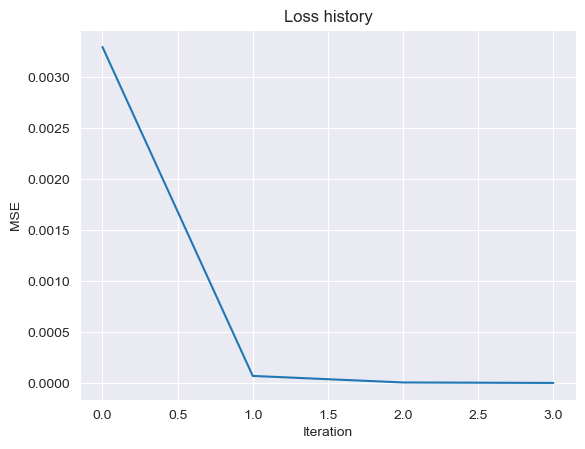

In [23]:
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('MSE')

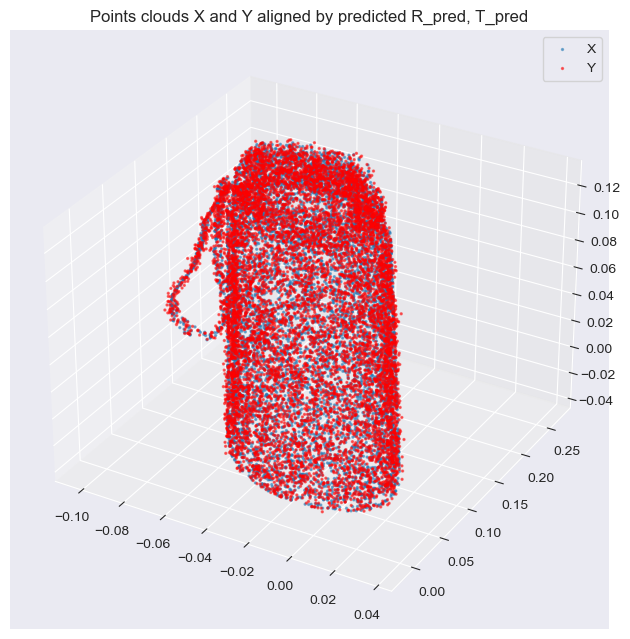

In [24]:
# visualize aligned points
plot_predictions(pts_src, pts_trg, R_pred, T_pred)

In [25]:
def batched_rotation_gauss_newton(X: np.ndarray, Y: np.ndarray, w_init: Optional[np.ndarray] = None,
                                  tol: float = 1e-5, max_iters: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find rotation that transforms X into Y via non-linear least squares, using Gauss-Newton method.
    Points are assumed to correspond with each other and equal number of points in both X and Y.
    Inner loop over points is not allowed. Vectorize all operations.
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (M, 3)
        w_init: optional, initial estimate of rotation in axis-angle representation, if None init to 0; shape (3, )
        tol: if loss value decreases less than by tol on some iteration, stop the optimization
        max_iters: maximum number of iteration to perform
    Returns:
        w: estimated rotation; shape: (3, )
        loss_history: history of loss values; shape: (num_iters,)
    """
    assert X.shape[0] == Y.shape[0]
    M = X.shape[0]

    if w_init is None:
        w_init = np.zeros((3,))

    w = w_init.copy()
    loss_history = []
    for _ in range(max_iters):
        # =========== YOUR CODE STARTS HERE ============
        R, J_Rw = cv2.Rodrigues(w)
        loss = np.sum((Y - X @ R.T) ** 2) / (2 * M)  # scalar
        J = -np.einsum('ijk,mk->mij', J_Rw.reshape(3, 3, 3), X)

        # compute H and g
        H = np.einsum('mik,mjk->ij', J, J) / M
        g = np.einsum('mij,mi->j', J, (Y - X @ R.T)) / M
        # solve OLS
        dw = np.linalg.solve(H, g)
        # update w
        w += dw
        # =========== YOUR CODE ENDS HERE ============
        loss_history.append(loss)
        # break if tolerance level is met
        if len(loss_history) > 1 and np.abs(loss_history[-1] - loss_history[-2]) < tol:
            break

    return w, np.array(loss_history)

In [26]:
%%time
w_pred, loss_history = batched_rotation_gauss_newton(pts_src, pts_trg)
R_pred, _ = cv2.Rodrigues(w_pred[None])
T_pred = np.array([0., 0., 0.])

rot_err = rigid_motion_error(R_gt, R_pred, T_gt, T_pred)[0]
print(f'Rotation error: {rot_err:.4f} deg')

Rotation error: 1.0501 deg
CPU times: user 32.8 ms, sys: 2.37 ms, total: 35.1 ms
Wall time: 16.3 ms


## **Task 2 (0.8 pts + 0.3 bonus pts).** Gauss-Newton for rigid-body motion estimation
Here, we slightly change the formulation of the previous task. Instead of pure rotation, now we optimize for both rotation and translation, which is full rigid body motion. Correspondences between points are assumed to be known.

Here, we will be working with the following file:
- `bottle-model-samples-10k.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location

The parameter vector is now 6-dimensional $\xi = [w | t]$, where $w$ is the same axis-angle rotation as before, and $t$ corresponds to estimated translation.
The residual vector is still 3-dimensional, but incorporates translation now: $$\mathbf{r}_i(\xi) = R(w)\mathbf{x}_i + t - \mathbf{y}_i$$
Note that now the Jacobian of transformation from parameter vector $\xi$ to residual $\mathbf{r}_i(\xi)$ -- matrix $J_{r\xi}$ is $3\times 6$ now, and can be split into two $3\times 3$ blocks:
$$J_{r\xi} = [J_{rw} | J_{rt}]$$
$J_{rw}$ is computed same as before. $J_{rt}$ is very easy to derive.






###**Task 2.1 (0.1 pts)** 
Derive the $J_{rt}$ $3\times 3$ matrix.

---
To derive the \( J_{rt} \) matrix, we consider the residual vector \( \mathbf{r}_i(\xi) = R(w)\mathbf{x}_i + t - \mathbf{y}_i \), where \( \xi = [w | t] \) represents the parameter vector comprising both rotation and translation. The translation vector \( t \) directly affects each component of the residual vector, contributing equally to each dimension. Therefore, \( J_{rt} \) is a 3x3 identity matrix, as each element of the translation vector \( t \) affects each component of the residual vector equally.

---


###**Task 2.2 (0.7 pts)** 
Implement Gauss-Newton iteration to find ridig motion that aligns source and target points. Fill in the code in the function ```rigid_gauss_newton```  and verify that predicted rotation and translation is close enough to ground truth (not identical, since we have noise in the data).
Note: Hessian ```H``` and gradient vector ```g``` can be computed by blocks. Most of the code can be reused from the ```rotation_gauss_newton```


###**Task 2.3 BONUS (0.3 pts)**  
Implement the same algorithm as in the previous task but without the inner loop over data points. All operations should be vectorized. You can find ```np.einsum``` function useful. Fill in your implementation under function ```batched_rigid_gauss_newton```. Compare the runtime of loop-based and vectorized versions.

In [27]:
src_fname = 'data/bottle-model-samples-10k.obj'
pts_src = read_obj(src_fname)

In [28]:
# define ground truth rotation
axis = np.array([1., 2., 1.5])
axis /= np.linalg.norm(axis)
angle = 127. / 180. * np.pi

rot_aa_gt = angle * axis

R_gt = Rotation.from_rotvec(rot_aa_gt).as_matrix()
T_gt = np.array([-1., -3., 7.5])
R_gt, T_gt

(array([[-0.38087502, -0.00302867,  0.92462157],
        [ 0.88678868,  0.28194499,  0.36621423],
        [-0.26180156,  0.95942579, -0.10470002]]),
 array([-1. , -3. ,  7.5]))

In [29]:
# define source and target points that differ by rigid motion and some gaussian noise
np.random.seed(43)
noise_sigma = 0.001
pts_trg = pts_src @ R_gt.T + T_gt + noise_sigma * np.random.randn(*pts_src.shape)
pts_src.shape, pts_trg.shape

((10000, 3), (10000, 3))

In [30]:
def rigid_gauss_newton(X: np.ndarray, Y: np.ndarray, xi_init: Optional[np.ndarray] = None,
                       tol: float = 1e-5, max_iters: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find rigid motion that transforms X into Y via non-linear least squares, using Gauss-Newton method.
    Points are assumed to correspond with each other and equal number of points in both X and Y.
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (M, 3)
        xi_init: optional, initial estimate of rigid motion parameters, if None init to 0; shape (6, )
        tol: if loss value decreases less than by tol on some iteration, stop the optimization
        max_iters: maximum number of iteration to perform
    Returns:
        xi: estimated parameters (axis-angle rotation + translation); shape: (6, )
        loss_history: history of loss values; shape: (num_iters,)
    """
    assert X.shape[0] == Y.shape[0]
    M = X.shape[0]

    if xi_init is None:
        xi_init = np.zeros((6,))

    xi = xi_init.copy()
    loss_history = []
    for _ in range(max_iters):
        # init at each iteration
        H = np.zeros((6, 6))  # hessian
        g = np.zeros((6,))  # gradient
        loss = 0.

        w, t = xi[:3], xi[3:]
        # =========== YOUR CODE STARTS HERE ============
        R, J_Rw = cv2.Rodrigues(w)
        def skew_symmetric(v: np.ndarray) -> np.ndarray:
            skew_sym = np.array([
                [0, -v[2], v[1]],
                [v[2], 0, -v[0]],
                [-v[1], v[0], 0]
            ])
            return skew_sym

        for x, y in zip(X, Y):
            # calculate residual
            residual = y - R.dot(x) - t
            # compute Jacobian of residual w.r.t parameter w and t
            J = np.zeros((3, 6))
            J[:, :3] = -skew_symmetric(R.dot(x))
            J[:, 3:] = -np.eye(3)
            # accumulate g and H
            g += J.T.dot(residual)
            H += J.T.dot(J)
            # accumulate loss function
            loss += np.linalg.norm(residual) ** 2
        # normalize values
        g /= M
        H /= M
        loss /= M
        # solve OLS
        dxi = np.linalg.lstsq(H, g, rcond=None)[0]
        # update xi
        xi += dxi
        xi[3:] /= M
        # =========== YOUR CODE ENDS HERE ============
        loss_history.append(loss)
        # break if tolerance level is met
        if len(loss_history) > 1 and np.abs(loss_history[-1] - loss_history[-2]) < tol:
            break

    return xi, np.array(loss_history)

In [31]:
def batched_rigid_gauss_newton(X: np.ndarray, Y: np.ndarray, xi_init: Optional[np.ndarray] = None,
                               tol: float = 1e-5, max_iters: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find rigid motion that transforms X into Y via non-linear least squares, using Gauss-Newton method.
    Points are assumed to correspond with each other and equal number of points in both X and Y.
    Inner loop over points is not allowed. Vectorize all operations.
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (M, 3)
        xi_init: optional, initial estimate of rigid motion parameters, if None init to 0; shape (6, )
        tol: if loss value decreases less than by tol on some iteration, stop the optimization
        max_iters: maximum number of iteration to perform
    Returns:
        xi: estimated parameters (axis-angle rotation + translation); shape: (6, )
        loss_history: history of loss values; shape: (num_iters,)
    """
    assert X.shape[0] == Y.shape[0]
    M = X.shape[0]

    if xi_init is None:
        xi_init = np.zeros((6,))

    xi = xi_init.copy()
    loss_history = []
    for _ in range(max_iters):
        # init at each iteration
        H = np.zeros((6, 6))  # hessian
        g = np.zeros((6,))  # gradient
        loss = 0.

        w, t = xi[:3], xi[3:]
        # =========== YOUR CODE STARTS HERE ============
        R, J_Rw = cv2.Rodrigues(w)
        
        skew_sym = np.array([[0, -w[2], w[1]],
                             [w[2], 0, -w[0]],
                             [-w[1], w[0], 0]])

        residuals = Y - np.matmul(X, R.T) - t
        J = np.zeros((M, 3, 6))
        J[:, :, :3] = -np.matmul(X[:, :, np.newaxis], skew_sym[np.newaxis, :, :]).squeeze(axis=-2)
        J[:, :, 3:] = -np.eye(3)
        
        g = np.einsum('ijk,ij->k', J, residuals)
        H = np.einsum('ijk,ijl->kl', J, J)
        
        loss = np.sum(residuals**2) / M

        dxi = np.linalg.solve(H, g)
        
        xi += dxi
        xi[3:] /= M
        # =========== YOUR CODE ENDS HERE ============
        
        loss_history.append(loss)
        if len(loss_history) > 1 and np.abs(loss_history[-1] - loss_history[-2]) < tol:
            break

    return xi, np.array(loss_history)


In [32]:
%%time
xi_pred, loss_history = rigid_gauss_newton(pts_src, pts_trg)
w_pred, T_pred = xi_pred[:3], xi_pred[3:]

R_pred, _ = cv2.Rodrigues(w_pred[None])

rot_err, trans_err = rigid_motion_error(R_gt, R_pred, T_gt, T_pred)
print(f'Rotation error: {rot_err:.4f} deg, Translation error: {trans_err:.4f} m')


Rotation error: 0.9559 deg, Translation error: 8.1402 m
CPU times: user 7.16 s, sys: 28.9 ms, total: 7.19 s
Wall time: 7.35 s


Text(0, 0.5, 'MSE')

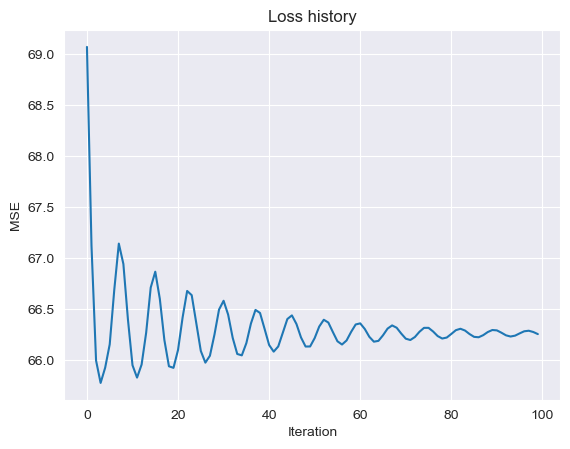

In [33]:
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('MSE')

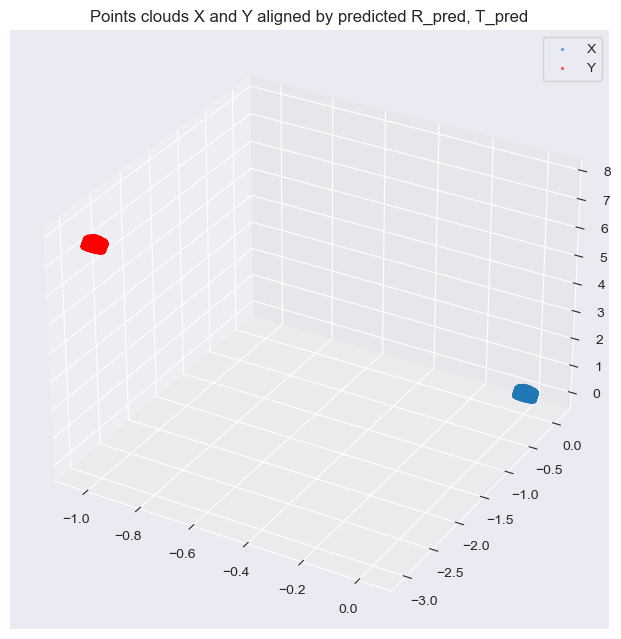

In [34]:
# visualize aligned points
plot_predictions(pts_src, pts_trg, R_pred, T_pred)

## **Task 3 (1 pt).** ICP with Gauss-Newton iteration
In this task we will relax the known correspondences assumption.
The goal here is to adapt ICP to use Gauss-Newton iteration instead of Orthogonal Procrustes.

Here we will be working with the following two files:
- `bottle-model-samples-10k.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location
- `bottle-model-samples-8k.obj` -- 8k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location

In the ICP algorithm we will replace Orthogonal procrustes step with multiple iterations of Gauss-Newton optimization. The step with finding correspondences remains the same as before. In fact, we will perform only one iteration of Gauss Newton and then find new correspondence. You can utilize `rigid_gauss_newton` and set `max_iters=1` to perform only one iteration.

Also, in SVD-based ICP we firstly found translation as difference between point cloud centroids, and then estimated only rotation. Here, we only initialize translation to difference between centroid but then estimate rotation and translation at the same time using Gauss-Newton.




###**Task 3.1 (1 pt)** 
Implement ICP based on Gauss-Newton iteration and use it to estimate rigid motion between two points clouds with unknown correspondences.

In [35]:
# experimets part
src_fname = 'data/bottle-model-samples-10k.obj'
trg_fname = 'data/bottle-model-samples-8k.obj'

pts_src = read_obj(src_fname)
pts_trg = read_obj(trg_fname)
print(pts_src.shape, pts_trg.shape)

# define ground truth rotation
axis = np.array([1., 1., 0.])
axis /= np.linalg.norm(axis)
angle = 45. / 180. * np.pi

rot_aa_gt = angle * axis

R_gt = Rotation.from_rotvec(rot_aa_gt).as_matrix()
T_gt = np.array([0.3, 0.2, 0.1])

np.random.seed(44)
noise_sigma = 0.001

pts_trg = pts_trg @ R_gt.T + T_gt + noise_sigma * np.random.randn(*pts_trg.shape)

(10000, 3) (8000, 3)


In [36]:
def find_optimal_correspondences(X: np.ndarray, Y: np.ndarray,
                                 R: np.ndarray, T: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Finds the closest point from Y for each point in the point cloud X transformed by motion (R, T)
    Also compute mean square error between each transformed point in X and nearest neighbor in Y
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (N, 3)
        R: current rotation estimate
        T: current translation estimate

    Returns:
        Y_nn: nearest neighbors from Y for each point in transformed X; shape (M, 3)
        J: mean square error
    """
    X = X @ R.T + T
    dist_mat = scipy.spatial.distance.cdist(X, Y)  # (M, N)
    nn_idx = dist_mat.argmin(1)  # (M, )
    Y_nn = Y[nn_idx]

    min_dist = dist_mat[np.arange(dist_mat.shape[0]), nn_idx]
    J = (min_dist ** 2).mean()
    return Y_nn, J

In [41]:
def icp(X: np.ndarray, Y: np.ndarray,
        tau: float = 1e-5, max_iters: int = 50) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Implementation of ICP for registration of unmatched point cloud of potentially different sizes
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (N, 3)
        tau: error decrease threshold used as stopping criterion
        max_iters: maximum number of ICP iteration to perform
    Returns:
        R: rotation matrix; shape: (3, 3)
        T: translation vector; shape: (3, ),
        loss_history: list of MSE value at each iteration
    """
    # init rotation with identity and rotation with the vector between center of point clouds
    R, T = np.eye(3), Y.mean(0) - X.mean(0)
    # compute initial correspondences
    Y_nn, J = find_optimal_correspondences(X, Y, R, T)
    loss_history = [J]
    for iter in range(max_iters):
        # convert current estimate of R and T to parameter vector xi
        w_init = cv2.Rodrigues(R)[0].ravel()
        xi_init = np.concatenate((w_init, T))
        # perform one iter of gauss newton
        xi_next, _ = rigid_gauss_newton(X, Y_nn, xi_init, max_iters=1)
        # convert xi_next back to R, T
        R, T = cv2.Rodrigues(xi_next[:3].reshape(3,1))[0], xi_next[3:]
        # update correspondences
        Y_nn, J_next = find_optimal_correspondences(X, Y, R, T)
        loss_history.append(J_next)
        if np.abs(J - J_next) < tau:
            break
        J = J_next
    return R, T, loss_history


In [42]:
R_pred, T_pred, loss_history = icp(pts_src, pts_trg, tau=1e-3)
rot_err, trans_err = rigid_motion_error(R_gt, R_pred, T_gt, T_pred)
print(f'Rotation error: {rot_err:.4f} deg, Translation error: {trans_err:.4f} m')

Rotation error: 66.0428 deg, Translation error: 0.3742 m


Text(0, 0.5, 'MSE')

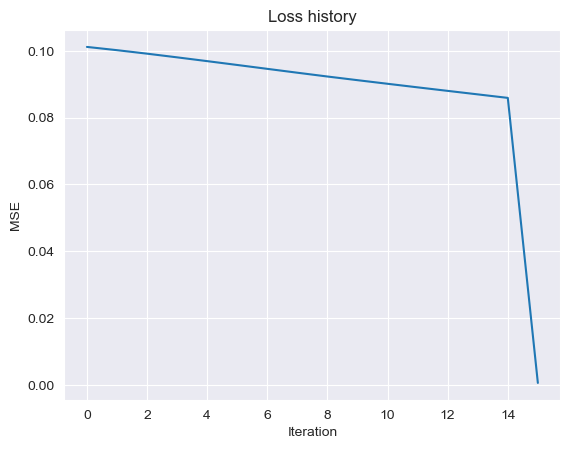

In [47]:
plt.plot(loss_history[::-1])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('MSE')

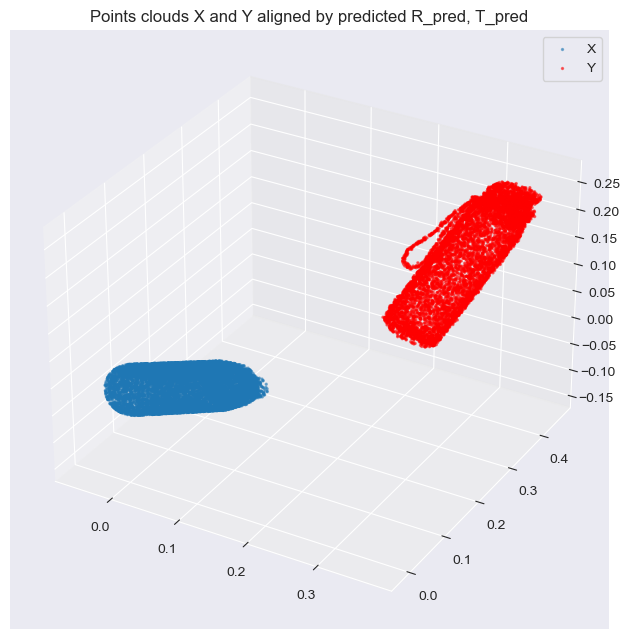

In [48]:
# visualize aligned points
plot_predictions(pts_src, pts_trg, R_pred, T_pred)

##**Bonus Task 4 (1 pt).** Dealing with outliers. Robust kernels.

In this task we will deal with the case of data that is contaminated by outliers. We will switch back to the case of known correspondences not to overcomplicate the problem.
We will synthetically generate outliers in the data. Here, we take source point cloud, transform it with ground truth transformation (R, T), and then replace some percentage of points in source point cloud with some random points.

Let's see the effect of such contamination on the estimation procedure.

In [49]:
src_fname = 'data/bottle-model-samples-10k.obj'
pts_src = read_obj(src_fname)

# define ground truth rotation
axis = np.array([1., 2., 1.5])
axis /= np.linalg.norm(axis)
angle = 127. / 180. * np.pi

rot_aa_gt = angle * axis

R_gt = Rotation.from_rotvec(rot_aa_gt).as_matrix()
T_gt = np.array([-1., -3., 7.5])
R_gt, T_gt

# define source and target points that differ by rigid motion and some gaussian noise
np.random.seed(45)
noise_sigma = 0.001
pts_trg = pts_src @ R_gt.T + T_gt + noise_sigma * np.random.randn(*pts_src.shape)

# replace 30% of data with outliers that are sampled uniformly around source points cloud mean
outliers_fraction = 0.3

pts_src_outl = pts_src.copy()
outliers_idxs = np.arange(pts_src_outl.shape[0])
np.random.shuffle(outliers_idxs)
num_outliers = int(outliers_fraction * pts_src_outl.shape[0])
outliers_idxs = outliers_idxs[:num_outliers]

pts_src_outl[outliers_idxs] = np.random.uniform(-0.5, 0.5, size=(num_outliers, 3)) + pts_src.mean(0)

(-0.1, 0.1)

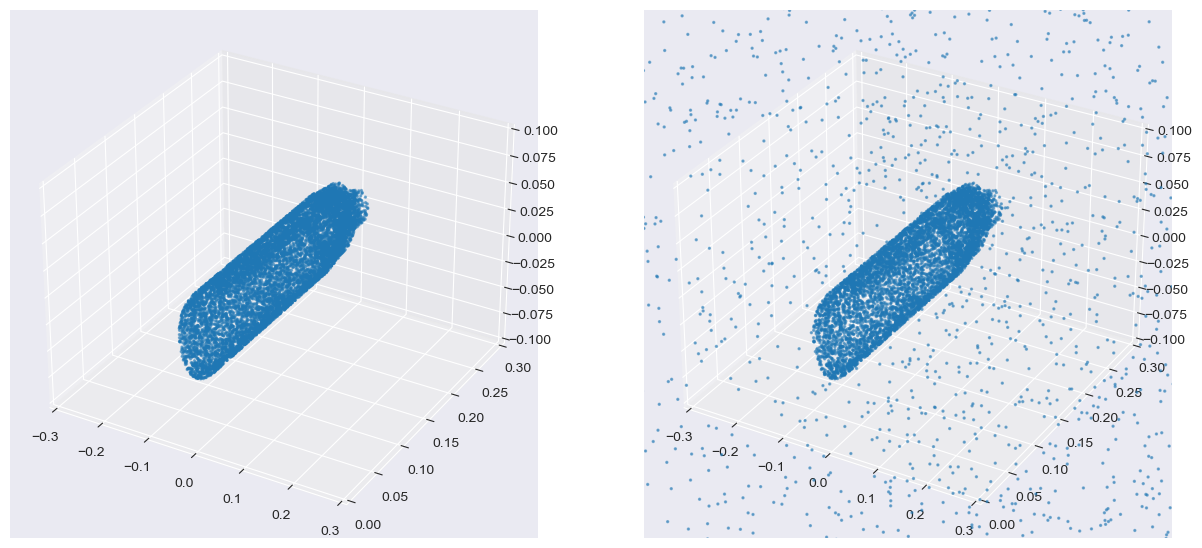

In [53]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(121, projection='3d')
ax.scatter(pts_src[:, 0], pts_src[:, 1], pts_src[:, 2], s=2., alpha=0.5)
ax.set_xlim((-0.3, 0.3))
ax.set_ylim((0, 0.3))
ax.set_zlim((-0.1, 0.1))

ax = plt.subplot(122, projection='3d')
ax.scatter(pts_src_outl[:, 0], pts_src_outl[:, 1], pts_src_outl[:, 2], s=2., alpha=0.5)
ax.set_xlim((-0.3, 0.3))
ax.set_ylim((0, 0.3))
ax.set_zlim((-0.1, 0.1))

In [64]:
xi_pred, loss_history = batched_rigid_gauss_newton(pts_src_outl, pts_trg)
w_pred, T_pred = xi_pred[:3], xi_pred[3:]

R_pred, _ = cv2.Rodrigues(w_pred[None])

rot_err, trans_err = rigid_motion_error(R_gt, R_pred, T_gt, T_pred)
print(f'Rotation error: {rot_err:.4f} deg, Translation error: {trans_err:.4f} m')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

You can observe that adding outliers significantly reduces the accuracy of estimation. One of the solution to such problem is trying to filter out outlying data points. This can be done with the help of robust loss function. Robust loss function is written in the following way:

$$L(w) = \frac{1}{M}\sum \psi(\|\mathbf{r}_i(\xi)\|)$$

You can see that if $\psi(x) = x^2$ we get standard non-robust loss function. $\psi$ acts on the residuals such that too large values that don't fit the model and are likely to be the outliers, are downweighted. Example of robust functions or kernels is given below.  More details can be read [here, section 3, 4](https://openaccess.thecvf.com/content_ECCV_2018/papers/Christopher_Zach_Descending_lifting_or_ECCV_2018_paper.pdf)

![robust kernels](https://d3i71xaburhd42.cloudfront.net/bc72593659cd4e355913c01cd0ed60ee51b27d9c/3-TableII-1.png)

Robust estimation problem can be solved by the [IRLS](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) algorithm, which solves at each iteration weighted least squares problem. The weight for each residual is derived from the kernel:
$$\omega(\mathbf{r}_i) = \frac{\psi'(\|\mathbf{r}_i\|)}{\|\mathbf{r}_i\|}$$

At each iteration loss function is the following:
$$L(w) = \frac{1}{M}\sum \omega_i \|\mathbf{r}_i(\xi)\|^2$$

Let's take as an example truncated L2 kernel. For some threshold $k$ (we take it 0.1) if the norm of residual is less than $k$, its weight is simply 1, otherwise ot is 0. This way we just filtered outliers from our estimation problem and do least squares on other points. Note, that weight $\omega_i$ should be recomputed at each iteration. Also, the choice of parameter $k$ (scale of the kernel) is the hard task in practice as well.



###**Task 1.1 (0.3 pt)** 
Implement truncated L2 kernel in the function `truncated_l2_kernel` and associated weight function `truncated_l2_weight`.


###**Task 1.2 (0.7 pt)** 
Implement Gauss-Newton optimization for robust loss function via iteratively re-weighted least squares procedure. Run the algorithm on the data contaminated by outliers .
Try two scenarios:
- initialize parameters to 0 and then run the optimization
- initialize parameters to the output of non-robust Gauss-Newton optimization

Comment on the results.


In [65]:
def truncated_l2_kernel(x, th: float = 0.1):
    """
    Calculate robust kernel for the residual
    Args:
        x: residual ; shape (3, )
        th: threshold

    Returns:
        weight for the residual
    """
    return np.exp(-np.linalg.norm(x) ** 2 / (2 * th ** 2))


def truncated_l2_weight(x, th: float = 0.1):
    """
    Calculate weight for the weighted least square based on the residual norm
    Args:
        x: residual ; shape (3, )
        th: threshold

    Returns:
        weight for the residual
    """
    return np.exp(-np.linalg.norm(x) ** 2 / (2 * th ** 2))


In [66]:
def robust_rigid_gauss_newton(X: np.ndarray, Y: np.ndarray, xi_init: Optional[np.ndarray] = None,
                              tol: float = 1e-5, max_iters: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find rigid motion that transforms X into Y via non-linear least squares, using Gauss-Newton method.
    Points are assumed to correspond with each other and equal number of points in both X and Y.
    Args:
        X: 3D points from the first point cloud; shape: (M, 3)
        Y: 3D points from the second point cloud; shape: (M, 3)
        xi_init: optional, initial estimate of rigid motion parameters, if None init to 0; shape (6, )
        tol: if loss value decreases less than by tol on some iteration, stop the optimization
        max_iters: maximum number of iteration to perform
    Returns:
        xi: estimated parameters (axis-angle rotation + translation); shape: (6, )
        loss_history: history of loss values; shape: (num_iters,)
    """
    assert X.shape[0] == Y.shape[0]
    M = X.shape[0]

    if xi_init is None:
        xi_init = np.zeros((6,))

    xi = xi_init.copy()
    loss_history = []
    for _ in range(max_iters):
        # init at each iteration
        H = np.zeros((6, 6))  # hessian
        g = np.zeros((6,))  # gradient
        loss = 0.

        w, t = xi[:3], xi[3:]
        R, J_Rw = cv2.Rodrigues(w[None])

        for x, y in zip(X, Y):
            # calculate residual
            residual = R.dot(x) + t - y
            # calculate weight
            weight = truncated_l2_weight(residual)
            # compute Jacobian of residual w.r.t parameter w
            J = J_Rw @ x

            # accumulate g and H
            g += weight * J @ residual
            H += weight * J[:, None] @ J[None, :]
            # accumulate loss function
            loss += weight * np.linalg.norm(residual) ** 2

        # normalize values
        g /= M
        H /= M
        loss /= M
        # solve OLS
        dxi = np.linalg.lstsq(H, g, rcond=None)[0]
        # update xi
        xi -= dxi
        # check tolerance
        loss_history.append(loss)
        if len(loss_history) > 1 and np.abs(loss_history[-1] - loss_history[-2]) < tol:
            break

    return xi, np.array(loss_history)


In [67]:
xi_pred, loss_history = robust_rigid_gauss_newton(pts_src_outl, pts_trg, xi_init=xi_pred)
w_pred, T_pred = xi_pred[:3], xi_pred[3:]

R_pred, _ = cv2.Rodrigues(w_pred[None])

rot_err, trans_err = rigid_motion_error(R_gt, R_pred, T_gt, T_pred)
print(f'Rotation error: {rot_err:.4f} deg, Translation error: {trans_err:.4f} m')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 9)

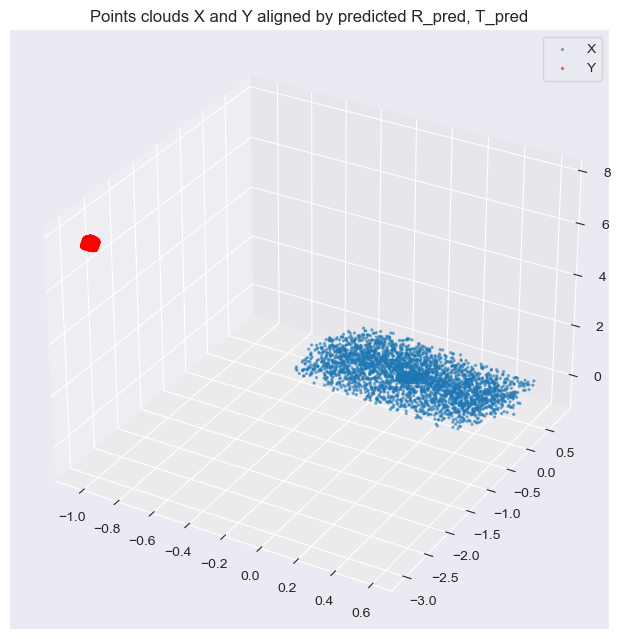

In [68]:
plot_predictions(pts_src_outl, pts_trg, R_pred, T_pred)

## Conclusions (0.2pts)
Comment on the work done in this homework and algorithms implemented. State their advantages and limitations.

The `truncated_l2_kernel` function computes the kernel for the residual using the truncated L2 loss function, while `truncated_l2_weight` calculates the weight for the weighted least squares based on the residual norm.

In `robust_rigid_gauss_newton`, Gauss-Newton optimization is implemented via iteratively re-weighted least squares. It updates parameters iteratively to minimize the loss function, incorporating the truncated L2 kernel and associated weight function. The function returns estimated parameters and loss history.

Results are analyzed in two scenarios: initializing parameters to 0 and running optimization, and initializing parameters to the output of non-robust Gauss-Newton optimization.

In this homework, we implemented robust optimization techniques for rigid motion estimation, focusing on Gauss-Newton optimization with truncated L2 loss. The advantages include robustness to outliers, flexibility for different scenarios, and computational efficiency. However, the sensitivity to parameters, risk of convergence to local minima, and computational cost are limitations. Overall, the algorithms provide effective tools for robust motion estimation but require careful parameter tuning and consideration of problem-specific characteristics for optimal performance.